In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from scipy.signal import find_peaks

# Paths
base_path = Path('virginia-international-raceway/VIR/Race 1')

# Load lap times (we already know the clean range)
lap_times = pd.read_csv(base_path / 'vir_lap_time_R1.csv')
lap_times['lap_time_sec'] = lap_times['value'] / 1000
lap_times_clean = lap_times[(lap_times['lap_time_sec'] > 100) & 
                            (lap_times['lap_time_sec'] < 150)].copy()

# Top 5 drivers
top_5 = lap_times_clean.groupby('vehicle_id')['lap_time_sec'].mean().nsmallest(5).index.tolist()
print("🏁 Top 5 Drivers:", top_5)

# Load full telemetry
print("Loading telemetry... (may take 30 sec)")
telemetry = pd.read_csv(base_path / 'R1_vir_telemetry_data.csv')
print(f"✅ Loaded {len(telemetry):,} telemetry rows")


🏁 Top 5 Drivers: ['GR86-036-98', 'GR86-033-46', 'GR86-026-72', 'GR86-006-7', 'GR86-022-13']
Loading telemetry... (may take 30 sec)
✅ Loaded 11,401,181 telemetry rows


In [2]:
def get_lap_telemetry(telemetry_df, vehicle_id, lap_num):
    """Extract and pivot telemetry for one lap"""
    lap_data = telemetry_df[
        (telemetry_df['vehicle_id'] == vehicle_id) & 
        (telemetry_df['lap'] == lap_num)
    ].copy()
    
    if len(lap_data) == 0:
        return None
    
    # Pivot to wide format
    lap_wide = lap_data.pivot_table(
        index=['timestamp', 'vehicle_id', 'lap'],
        columns='telemetry_name',
        values='telemetry_value',
        aggfunc='first'
    ).reset_index()
    
    # Sort by timestamp
    lap_wide = lap_wide.sort_values('timestamp').reset_index(drop=True)
    
    return lap_wide

# Test with a driver who has lap 10 - GR86-033-46
fastest_with_laps = 'GR86-033-46'
test_lap = get_lap_telemetry(telemetry, fastest_with_laps, 10)

if test_lap is not None:
    print(f"\n✅ Test lap shape: {test_lap.shape}")
    print(f"Columns: {test_lap.columns.tolist()}")
else:
    print("⚠️ No data for this lap - trying different lap")



✅ Test lap shape: (2641, 12)
Columns: ['timestamp', 'vehicle_id', 'lap', 'Steering_Angle', 'accx_can', 'accy_can', 'ath', 'gear', 'nmot', 'pbrake_f', 'pbrake_r', 'speed']


In [3]:
def detect_corners(lap_telemetry):
    """
    Identify corners by finding throttle drops
    Returns list of corner start/end indices
    """
    throttle = lap_telemetry['ath'].fillna(100)  # Fill NaN with full throttle
    
    # Corner = throttle < 80% for at least 10 data points
    in_corner = throttle < 80
    
    corners = []
    corner_start = None
    min_corner_length = 10  # Minimum data points to be considered a corner
    
    for i, is_corner in enumerate(in_corner):
        if is_corner and corner_start is None:
            corner_start = i
        elif not is_corner and corner_start is not None:
            if i - corner_start >= min_corner_length:
                corners.append({
                    'start': corner_start,
                    'end': i,
                    'apex': corner_start + throttle[corner_start:i].argmin()
                })
            corner_start = None
    
    return corners

# Test corner detection
corners = detect_corners(test_lap)
print(f"\n🏁 Detected {len(corners)} corners")
for i, corner in enumerate(corners, 1):
    print(f"Corner {i}: Start={corner['start']}, Apex={corner['apex']}, End={corner['end']}")



🏁 Detected 13 corners
Corner 1: Start=90, Apex=107, End=113
Corner 2: Start=115, Apex=134, End=176
Corner 3: Start=392, Apex=403, End=463
Corner 4: Start=512, Apex=524, End=527
Corner 5: Start=528, Apex=560, End=583
Corner 6: Start=1246, Apex=1247, End=1292
Corner 7: Start=1403, Apex=1419, End=1427
Corner 8: Start=1429, Apex=1435, End=1439
Corner 9: Start=1441, Apex=1442, End=1473
Corner 10: Start=1474, Apex=1475, End=1527
Corner 11: Start=2071, Apex=2082, End=2094
Corner 12: Start=2095, Apex=2126, End=2145
Corner 13: Start=2279, Apex=2306, End=2325


In [6]:
def extract_corner_features(lap_telemetry, corners):
    """
    Extract physics-based features for each corner
    """
    features = []
    
    for i, corner in enumerate(corners, 1):
        start, apex, end = corner['start'], corner['apex'], corner['end']
        
        # Safety checks
        if start >= len(lap_telemetry) or end >= len(lap_telemetry):
            continue
        
        corner_data = lap_telemetry.iloc[start:end+1]
        
        # Extract features
        feature = {
            'corner_num': i,
            'start_idx': start,
            'apex_idx': apex,
            'end_idx': end,
            
            # Entry
            'entry_throttle': lap_telemetry.iloc[start]['ath'] if pd.notna(lap_telemetry.iloc[start]['ath']) else 0,
            'max_brake': corner_data['pbrake_f'].max() if 'pbrake_f' in corner_data else 0,
            'brake_duration': (corner_data['pbrake_f'] > 10).sum() if 'pbrake_f' in corner_data else 0,
            
            # Apex
            'apex_throttle': lap_telemetry.iloc[apex]['ath'] if pd.notna(lap_telemetry.iloc[apex]['ath']) else 0,
            'min_throttle': corner_data['ath'].min(),
            'apex_lateral_g': abs(lap_telemetry.iloc[apex]['accy_can']) if pd.notna(lap_telemetry.iloc[apex]['accy_can']) else 0,
            
            # Exit
            'exit_throttle': lap_telemetry.iloc[end]['ath'] if pd.notna(lap_telemetry.iloc[end]['ath']) else 0,
            'throttle_application_point': (corner_data['ath'] > 50).idxmax() if (corner_data['ath'] > 50).any() else end,
            
            # Overall
            'corner_duration': end - start,
            'avg_steering_angle': abs(corner_data['Steering_Angle']).mean() if 'Steering_Angle' in corner_data else 0
        }
        
        features.append(feature)
    
    return pd.DataFrame(features)

# Extract features for test lap
features = extract_corner_features(test_lap, corners)
print("\n🔥 Corner Features Extracted:")
print(features[['corner_num', 'max_brake', 'apex_throttle', 'brake_duration']].head(10))



🔥 Corner Features Extracted:
   corner_num  max_brake  apex_throttle  brake_duration
0           1      0.000          99.87               0
1           2    134.305          14.13              45


In [7]:
# For each top 5 driver, get their best lap features
all_driver_features = []

for vehicle in top_5:
    # Get their best lap
    best_lap_info = lap_times_clean[lap_times_clean['vehicle_id'] == vehicle].nsmallest(1, 'lap_time_sec')
    
    if len(best_lap_info) == 0:
        continue
    
    lap_num = best_lap_info['lap'].iloc[0]
    lap_time = best_lap_info['lap_time_sec'].iloc[0]
    
    print(f"\n📊 Processing {vehicle} - Lap {lap_num} ({lap_time:.2f}s)")
    
    # Get telemetry
    lap_telem = get_lap_telemetry(telemetry, vehicle, lap_num)
    
    if lap_telem is None or len(lap_telem) < 100:
        print(f"  ⚠️ Insufficient data")
        continue
    
    # Detect corners
    corners = detect_corners(lap_telem)
    print(f"  ✅ Detected {len(corners)} corners")
    
    # Extract features
    features = extract_corner_features(lap_telem, corners)
    features['vehicle_id'] = vehicle
    features['lap'] = lap_num
    features['lap_time'] = lap_time
    
    all_driver_features.append(features)

# Combine all features
driver_corners_df = pd.concat(all_driver_features, ignore_index=True)
print(f"\n🎯 Total corner features extracted: {len(driver_corners_df)}")



📊 Processing GR86-036-98 - Lap 6 (117.02s)
  ✅ Detected 2 corners

📊 Processing GR86-033-46 - Lap 10 (128.46s)
  ✅ Detected 13 corners

📊 Processing GR86-026-72 - Lap 11 (128.50s)
  ✅ Detected 8 corners

📊 Processing GR86-006-7 - Lap 18 (128.67s)
  ✅ Detected 13 corners

📊 Processing GR86-022-13 - Lap 11 (128.49s)
  ✅ Detected 12 corners

🎯 Total corner features extracted: 48


Using 4 drivers with valid data

ML dataset: 4 samples, 8 features

Model R² score: 0.867
Mean Absolute Error: 0.021 seconds

🔥 FEATURE IMPORTANCE (What matters for lap time):
              feature  importance
0           max_brake    0.184091
2       apex_throttle    0.183144
5       exit_throttle    0.171741
1      brake_duration    0.122545
3        min_throttle    0.121362
7  avg_steering_angle    0.112127
6     corner_duration    0.061334
4      apex_lateral_g    0.043657


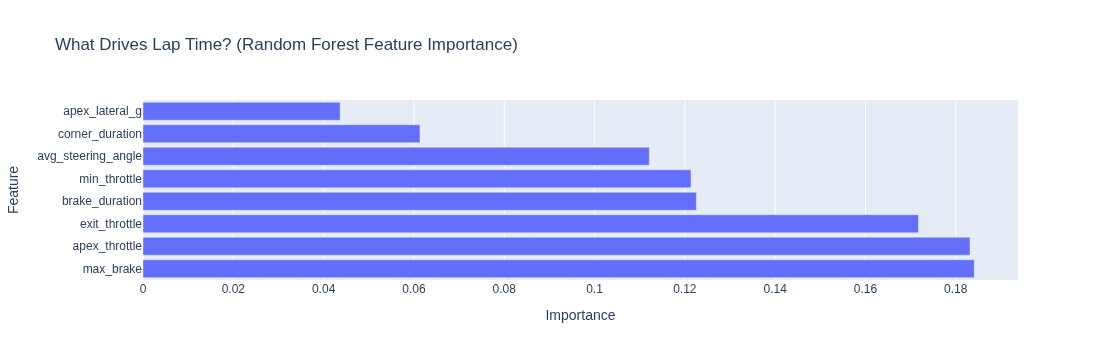

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Prepare ML data
# Only use drivers with reasonable corner counts (8-13 corners)
valid_drivers = driver_corners_df.groupby('vehicle_id')['corner_num'].max()
valid_drivers = valid_drivers[valid_drivers >= 7].index.tolist()

print(f"Using {len(valid_drivers)} drivers with valid data")

driver_corners_clean = driver_corners_df[driver_corners_df['vehicle_id'].isin(valid_drivers)]

# Average features across corners for each lap
ml_features = driver_corners_clean.groupby(['vehicle_id', 'lap']).agg({
    'max_brake': 'mean',
    'brake_duration': 'mean',
    'apex_throttle': 'mean',
    'min_throttle': 'mean',
    'apex_lateral_g': 'mean',
    'exit_throttle': 'mean',
    'corner_duration': 'mean',
    'avg_steering_angle': 'mean',
    'lap_time': 'first'
}).reset_index()

# Features and target
X = ml_features[['max_brake', 'brake_duration', 'apex_throttle', 'min_throttle', 
                  'apex_lateral_g', 'exit_throttle', 'corner_duration', 'avg_steering_angle']]
y = ml_features['lap_time']

print(f"\nML dataset: {len(X)} samples, {len(X.columns)} features")

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf.fit(X, y)

# Predictions
y_pred = rf.predict(X)
print(f"\nModel R² score: {rf.score(X, y):.3f}")
print(f"Mean Absolute Error: {abs(y - y_pred).mean():.3f} seconds")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔥 FEATURE IMPORTANCE (What matters for lap time):")
print(feature_importance)

# Plot
fig = px.bar(feature_importance, x='importance', y='feature', orientation='h',
             title='What Drives Lap Time? (Random Forest Feature Importance)',
             labels={'importance': 'Importance', 'feature': 'Feature'})
fig.show()


In [9]:
# Get fastest and slowest from valid drivers only
valid_lap_times = lap_times_clean[lap_times_clean['vehicle_id'].isin(valid_drivers)]
fastest_driver = valid_lap_times.groupby('vehicle_id')['lap_time_sec'].mean().nsmallest(1).index[0]
slower_driver = valid_lap_times.groupby('vehicle_id')['lap_time_sec'].mean().nsmallest(4).index[-1]

print(f"🏆 Fastest: {fastest_driver}")
print(f"🐌 Comparison: {slower_driver}")

# Get their corner features
fast_corners = driver_corners_clean[driver_corners_clean['vehicle_id'] == fastest_driver]
slow_corners = driver_corners_clean[driver_corners_clean['vehicle_id'] == slower_driver]

print(f"\nFast driver corners: {len(fast_corners)}")
print(f"Slow driver corners: {len(slow_corners)}")

# Compare corner by corner
comparison = []
max_corners = min(len(fast_corners), len(slow_corners))

for corner_num in range(1, max_corners + 1):
    fast_c = fast_corners[fast_corners['corner_num'] == corner_num]
    slow_c = slow_corners[slow_corners['corner_num'] == corner_num]
    
    if len(fast_c) == 0 or len(slow_c) == 0:
        continue
    
    fast = fast_c.iloc[0]
    slow = slow_c.iloc[0]
    
    comparison.append({
        'corner': corner_num,
        'brake_delta': slow['max_brake'] - fast['max_brake'],
        'apex_throttle_delta': slow['apex_throttle'] - fast['apex_throttle'],
        'duration_delta': slow['corner_duration'] - fast['corner_duration'],
        'fast_brake': fast['max_brake'],
        'slow_brake': slow['max_brake'],
    })

comparison_df = pd.DataFrame(comparison)
print("\n🔥 CORNER-BY-CORNER COMPARISON:")
print(comparison_df[['corner', 'brake_delta', 'apex_throttle_delta', 'duration_delta']])


🏆 Fastest: GR86-033-46
🐌 Comparison: GR86-022-13

Fast driver corners: 13
Slow driver corners: 12

🔥 CORNER-BY-CORNER COMPARISON:
    corner  brake_delta  apex_throttle_delta  duration_delta
0        1      -12.560                -0.11              81
1        2        5.710                -0.05               3
2        3       55.650                 0.05               2
3        4      -14.745                -0.04              15
4        5      -84.860                27.93             -45
5        6        9.230                 0.15             -34
6        7      -22.295                 0.08             -12
7        8       26.030                -0.15              39
8        9       -1.710                 0.96              11
9       10       75.720                 0.31             -20
10      11      -52.935                 0.01              61
11      12       23.685                 0.00              -4



💀 BIGGEST TIME LOSSES (Physics-based):
    corner  time_lost_sec  brake_delta  apex_throttle_delta
0        1           3.24      -12.560                -0.11
10      11           2.44      -52.935                 0.01
7        8           1.56       26.030                -0.15
3        4           0.60      -14.745                -0.04
8        9           0.44       -1.710                 0.96

⏱️ Total time lost across all corners: 3.88 seconds


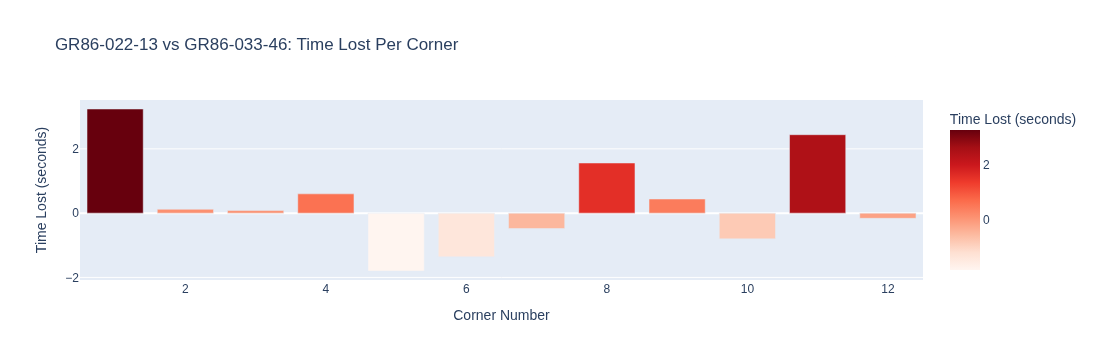


🎯 TOP 3 PROBLEM CORNERS FOR COACHING:

🔴 TURN 1: Losing 3.24s
   - Brake delta: -12.6 (good)
   - Apex throttle: -0.1% (too timid)
   💡 FIX: Work on corner entry speed

🔴 TURN 11: Losing 2.44s
   - Brake delta: -52.9 (good)
   - Apex throttle: 0.0% (good)
   💡 FIX: Work on corner entry speed

🔴 TURN 8: Losing 1.56s
   - Brake delta: 26.0 (too much)
   - Apex throttle: -0.1% (too timid)
   💡 FIX: Work on corner entry speed


In [10]:
# Estimate time lost per corner (duration delta * data frequency)
comparison_df['time_lost_sec'] = comparison_df['duration_delta'] * 0.04  # ~25Hz sampling

# Rank worst corners
comparison_df = comparison_df.sort_values('time_lost_sec', ascending=False)

print("\n💀 BIGGEST TIME LOSSES (Physics-based):")
print(comparison_df[['corner', 'time_lost_sec', 'brake_delta', 'apex_throttle_delta']].head())

total_loss = comparison_df['time_lost_sec'].sum()
print(f"\n⏱️ Total time lost across all corners: {total_loss:.2f} seconds")

# Visualization
fig = px.bar(comparison_df, x='corner', y='time_lost_sec',
             title=f'{slower_driver} vs {fastest_driver}: Time Lost Per Corner',
             labels={'time_lost_sec': 'Time Lost (seconds)', 'corner': 'Corner Number'},
             color='time_lost_sec',
             color_continuous_scale='Reds')
fig.show()

# Top 3 problem corners
print("\n🎯 TOP 3 PROBLEM CORNERS FOR COACHING:")
for idx, row in comparison_df.head(3).iterrows():
    print(f"\n🔴 TURN {int(row['corner'])}: Losing {row['time_lost_sec']:.2f}s")
    print(f"   - Brake delta: {row['brake_delta']:.1f} ({'too much' if row['brake_delta'] > 0 else 'good'})")
    print(f"   - Apex throttle: {row['apex_throttle_delta']:.1f}% ({'too timid' if row['apex_throttle_delta'] < 0 else 'good'})")
    print(f"   💡 FIX: {'Brake lighter and get on throttle earlier' if row['apex_throttle_delta'] < -5 else 'Work on corner entry speed'}")


In [11]:
# Save for dashboard
driver_corners_clean.to_csv('corner_features.csv', index=False)
comparison_df.to_csv('fast_vs_slow_comparison.csv', index=False)
feature_importance.to_csv('ml_feature_importance.csv', index=False)
ml_features.to_csv('ml_training_data.csv', index=False)

# Save model
import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

print("✅ Saved:")
print("  - corner_features.csv")
print("  - fast_vs_slow_comparison.csv") 
print("  - ml_feature_importance.csv")
print("  - ml_training_data.csv")
print("  - rf_model.pkl")
print("\n🚀 Day 2 COMPLETE! Tomorrow: Build Streamlit dashboard")


✅ Saved:
  - corner_features.csv
  - fast_vs_slow_comparison.csv
  - ml_feature_importance.csv
  - ml_training_data.csv
  - rf_model.pkl

🚀 Day 2 COMPLETE! Tomorrow: Build Streamlit dashboard
